# Regularyzacja w modelu regresji - zbiór `longley`

In [110]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
import sklearn.metrics as metrics

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

# Zadanie - `longley`

Zbiór danych `longley` zawiera różne zmienne makroekonomiczne w USA, o których wiadomo, że są wysoce współliniowe.

`GNPDEFL` GNP implicit price deflator (1954=100)

`GNP` Gross National Produc

`UNEMP` number of unemployed.

`ARMED` number of people in the armed forces.

`POP` ‘noninstitutionalized’ population ≥ 14 years of age.

`YEAR` the year (time).

`TOTEMP` number of people employed.

1. Podziel zbiór na część treningową i testową w stosunku 7:3


2. Dopasuj na danych treningowych model regresji liniowej, w którym zmienną zależną jest zmienna `TOTEMP` a pozostałe cechy zmiennymi niezależnymi. Wyznacz jakość predykcji modelu obliczając na zbiorze testowym:
   - błąd średniokwadratowy, 
   - medianę błędu bezwzględnego. 
   
    
3. Dopasuj na danych treningowych model regresji grzbietowej:
   - znajdź optymalną wartość parametru $\alpha$ (GridSearchCV)
   - sporządź wykres wartości współczynników regresji względem parametru $\alpha$.
   - wyznacz jakość predykcji modelu obliczając na zbiorze testowym:
      - błąd średniokwadratowy, 
      - medianę błędu bezwzględnego.    


4. Dopasuj na danych treningowych model regresji Lasso:
   - znajdź optymalną wartość parametru $\alpha$ (GridSearchCV)
   - sporządź wykres wartości współczynników regresji względem parametru $\alpha$.
   - wyznacz jakość predykcji modelu obliczając na zbiorze testowym:
      - błąd średniokwadratowy, 
      - medianę błędu bezwzględnego. 
   
5. Dopasuj na danych treningowych model regresji wielomianowej z regularyzacją grzbietową:
   - znajdź optymalny stopień wielomianu i optymalną wartość parametru $\alpha$,
   - wyznacz jakość predykcji modelu obliczając na zbiorze testowym:
      - błąd średniokwadratowy, 
      - medianę błędu bezwzględnego. 

6. Dopasuj na danych treningowych model regresji wielomianowej z regularyzacją Lasso:
   - znajdź optymalny stopień wielomianu i optymalną wartość parametru $\alpha$,
   - wyznacz jakość predykcji modelu obliczając na zbiorze testowym:
      - błąd średniokwadratowy, 
      - medianę błędu bezwzględnego.

Rozwiązując powyższe zadanie staraj się automatyzować swoją analizę, tj. napisz funkcje:
- `pred_scores`, która zwraca słownik/ramkę danych miar predykcji dla zbudowanego modelu;
- `grid_search_alpha`, która znajduje optymalną wartość $\alpha$ dla modelu regresji z regularyzacją Ridge lub Lasso;
- `plot_coef_vs_alpha`, która służy do tworzenia wykresu zmian wartości współczynników w zależności od wzrostu parametru $\alpha$;
- `grid_search_power_and_alpha`, która znajduje optymalny stopień wielomianu oraz parametr $\alpha$ dla regresji wielomianowej z regularyzacją Ridge lub Lasso.

Przygotuj tak analizę aby na koniec przedstawić wszystkie wyniki w jednej tabeli.

In [111]:
longley = sm.datasets.longley.load_pandas()
longley.data.head()

,TOTEMP,GNPDEFL,GNP,UNEMP,ARMED,POP,YEAR
0,60323.0,83.0,234289.0,2356.0,1590.0,107608.0,1947.0
1,61122.0,88.5,259426.0,2325.0,1456.0,108632.0,1948.0
2,60171.0,88.2,258054.0,3682.0,1616.0,109773.0,1949.0
3,61187.0,89.5,284599.0,3351.0,1650.0,110929.0,1950.0
4,63221.0,96.2,328975.0,2099.0,3099.0,112075.0,1951.0


In [112]:
# zmienna niezależne i zależna 
X, y = longley.data.iloc[:, longley.data.columns != 'TOTEMP'], longley.data['TOTEMP']

In [113]:
# funkcja licząca miary dla modelu

def pred_scores(model, X, y):
    
    MSE = metrics.mean_squared_error(y_true=y, y_pred=model.predict(X))
    mAE = metrics.median_absolute_error(y_true=y, y_pred=model.predict(X))

    results = {}
    results['MSE'] = MSE
    results['mAE'] = mAE
    
    return results

In [114]:
# funkcja mająca znaleźć najlepszą alphę w regresji ridge czy lasso za pomocą kroswalidacji (zwraca najlepszą alphę)

def grid_search_alpha(model, X, y, params, scoring, cv=10):
    
    grid = GridSearchCV(make_pipeline(StandardScaler(), model),
                        params, scoring=scoring, cv=cv)
    
    grid.fit(X,y)
    return grid.best_params_

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
models = {}

## model liniowy

In [116]:
model_linear_regression = LinearRegression()
model_linear_regression.fit(X_train, y_train)

LinearRegression()

In [117]:
models['linear'] = pred_scores(model_linear_regression, X_test, y_test)
models['linear']

{'MSE': 382728.08877518284, 'mAE': 329.05365453101695}

## Ridge

In [118]:
best_alpha_ridge = grid_search_alpha(Ridge(), X_train, y_train,
                                     params={'ridge__alpha': np.linspace(0.00001, 0.01, 100)},
                                     scoring='neg_mean_squared_error',
                                     )

best_alpha_ridge['ridge__alpha']

0.0011200000000000001

In [119]:
ridge_alpha_opt = make_pipeline(StandardScaler(), Ridge(alpha=best_alpha_ridge['ridge__alpha']))
ridge_alpha_opt.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=0.0011200000000000001))])

In [120]:
models['ridge_%.3g' %best_alpha_ridge['ridge__alpha']] = pred_scores(ridge_alpha_opt, X_test, y_test)
models['ridge_%.3g' %best_alpha_ridge['ridge__alpha']]

{'MSE': 90491.32267512611, 'mAE': 218.8612205503523}

## Lasso

In [121]:
best_alpha_lasso = grid_search_alpha(Lasso(), X_train, y_train,
                                     params={'lasso__alpha': np.linspace(1e-14, 1e-12, 100)},
                                     scoring='neg_mean_squared_error',
                                     )

best_alpha_lasso['lasso__alpha']

3e-13

In [122]:
lasso_alpha_opt = make_pipeline(StandardScaler(), Lasso(alpha=best_alpha_lasso['lasso__alpha']))
lasso_alpha_opt.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=3e-13))])

In [123]:
models['lasso_%.3g' %best_alpha_lasso['lasso__alpha']] = pred_scores(lasso_alpha_opt, X_test, y_test)
models['lasso_%.3g' %best_alpha_lasso['lasso__alpha']]

{'MSE': 95963.70306611464, 'mAE': 94.85959379772248}

In [124]:
pd.DataFrame(models)

,linear,ridge_0.00112,lasso_3e-13
MSE,382728.088775,90491.322675,95963.703066
mAE,329.053655,218.861221,94.859594


In [125]:
# funkcja do stworzenia wykresu zmiany wartości współczynnika beta w zależności od zmiany alpha

def plot_coef_vs_alpha(model_name, min_alpha, max_alpha, poly_degree=1):
    
    alpha_vec =  np.linspace(min_alpha, max_alpha, 100)
    
    if (model_name == 'lasso'):
        model = Lasso(max_iter=10_000)
    
    elif(model_name == 'ridge'):
        model = Ridge()

    coefs = []
    for a in alpha_vec:
        
        model.alpha = a
        model_reg = make_pipeline(PolynomialFeatures(poly_degree), StandardScaler(), model)
        
        model_reg.fit(X_train, y_train)
        coefs.append(model_reg.named_steps[model_name].coef_[1:])

    plt.plot(alpha_vec, coefs)
    plt.plot([np.min(alpha_vec), np.max(alpha_vec)], [0, 0], '-.', color='black')
    plt.xlabel('alpha')
    plt.ylabel('coefficients')
    plt.legend(X_train.columns)
    plt.show()

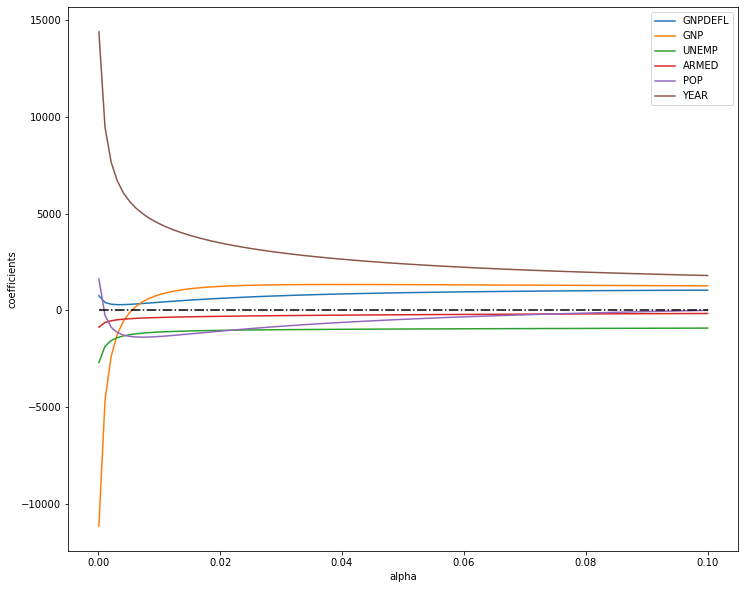

In [126]:
plot_coef_vs_alpha('ridge', 1e-4, 0.1)

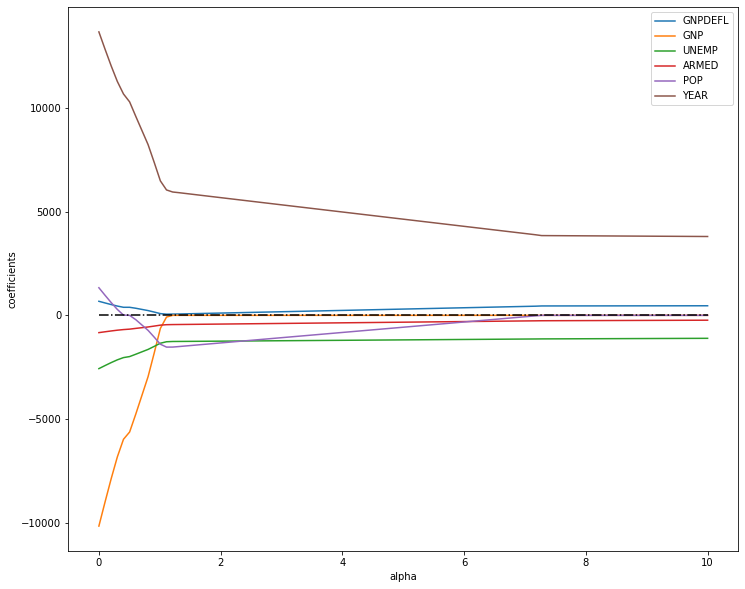

In [127]:
plot_coef_vs_alpha('lasso', 1e-5, 10)

In [128]:
# funkcja do znajdywania najlepszego zestawu parametrów degree i alpha

def grid_search_power_and_alpha(model, X, y, params, scoring, cv=10):
    
    grid = GridSearchCV(make_pipeline(PolynomialFeatures(), StandardScaler(), model),
                        params, scoring=scoring, cv=cv)
    
    grid.fit(X,y)
    return grid.best_params_

In [129]:
models2 = {}

## Ridge wielomianowy

In [130]:
best_params_ridge = grid_search_power_and_alpha(Ridge(), X_train, y_train,
                                     params={'polynomialfeatures__degree': [1, 2, 3],
                                             'ridge__alpha': np.linspace(1e-5, 2, 100)},
                                     scoring='neg_mean_squared_error'
                                     )

(best_params_ridge['polynomialfeatures__degree'], best_params_ridge['ridge__alpha'])  # najlepszy jest model liniowy

(1, 1e-05)

In [131]:
ridge_alpha_deg_opt =  make_pipeline(PolynomialFeatures(degree = best_params_ridge['polynomialfeatures__degree']),
                                     StandardScaler(),
                                     Ridge(alpha=best_params_ridge['ridge__alpha'])
                                     )

ridge_alpha_deg_opt.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=1e-05))])

In [132]:
models2['ridge_%.3g_%d' % (best_params_ridge['ridge__alpha'],
                       best_params_ridge['polynomialfeatures__degree'])] = pred_scores(ridge_alpha_deg_opt, X_test, y_test)

models2['ridge_%.3g_%d' % (best_params_ridge['ridge__alpha'],
                       best_params_ridge['polynomialfeatures__degree'])]

{'MSE': 373577.38565676135, 'mAE': 318.9132783452369}

## Lasso wielomianowe

In [133]:
# UWAGA: domyślna wartość 'max_iter' daje lepsze rezultaty: mae = 94

best_params_lasso = grid_search_power_and_alpha(Lasso(max_iter=10_000), X_train, y_train,
                                     params={'polynomialfeatures__degree': [1, 2, 3],
                                             'lasso__alpha': np.linspace(1e-5, 2, 100)},
                                     scoring='neg_mean_squared_error'
                                     )

(best_params_lasso['polynomialfeatures__degree'], best_params_lasso['lasso__alpha'])  # najlepszy jest model liniowy

(1, 0.7272790909090908)

In [134]:
lasso_alpha_deg_opt =  make_pipeline(PolynomialFeatures(degree = best_params_lasso['polynomialfeatures__degree']),
                                     StandardScaler(),
                                     Lasso(alpha=best_params_lasso['lasso__alpha'])
                                     )

lasso_alpha_deg_opt.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.7272790909090908))])

In [135]:
models2['lasso_%.3g_%d' % (best_params_lasso['lasso__alpha'],
                       best_params_lasso['polynomialfeatures__degree'])] = pred_scores(lasso_alpha_deg_opt, X_test, y_test)

models2['lasso_%.3g_%d' % (best_params_lasso['lasso__alpha'],
                       best_params_lasso['polynomialfeatures__degree'])]

{'MSE': 99652.06642806297, 'mAE': 106.2643585680562}

## wyniki końcowe

In [136]:
results = pd.concat([pd.DataFrame(models), pd.DataFrame(models2)], axis=1, sort=False)
results

,linear,ridge_0.00112,lasso_3e-13,ridge_1e-05_1,lasso_0.727_1
MSE,382728.088775,90491.322675,95963.703066,373577.385657,99652.066428
mAE,329.053655,218.861221,94.859594,318.913278,106.264359
